In [14]:
import logging
import pyvista as pv

from pointcept.supplemental.utils import *
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    plot_mesh_folds,
    crop_meshes_per_fold,
    save_fold_meshes
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../../data")
label = 'maritime_museum'

In [15]:
dh = DataHandler(label)
dh.ensure_meshes()

02:17:30 - INFO - Label maritime_museum does not currently have extracted meshes. Attempting now.
02:17:30 - INFO - Cleaning .bin extraction dirs.
02:17:30 - INFO - Splitting bin file ../../data/meshes/extracted/maritime_museum/maritime_museum.bin by category...
02:17:30 - INFO -   extracting category: 1_WALL
02:17:32 - INFO -   extracting category: 2_FLOOR
02:17:33 - INFO -   extracting category: 3_ROOF
02:17:35 - INFO -   extracting category: 4_CEILING
02:17:36 - INFO -   extracting category: 5_FOOTPATH
02:17:37 - INFO -   extracting category: 6_GRASS
02:17:37 - INFO -   extracting category: 7_COLUMN
02:17:38 - INFO -   extracting category: 8_DOOR
02:17:39 - INFO -   extracting category: 9_WINDOW
02:17:41 - INFO -   extracting category: 10_STAIR
02:17:42 - INFO -   extracting category: 11_RAILING
02:17:43 - INFO -   extracting category: 12_RWP
02:17:44 - INFO -   extracting category: 13_OTHER
02:17:45 - INFO -   converting 1_wall.bin
02:17:46 - INFO -   converting 2_floor.bin
02:17:4

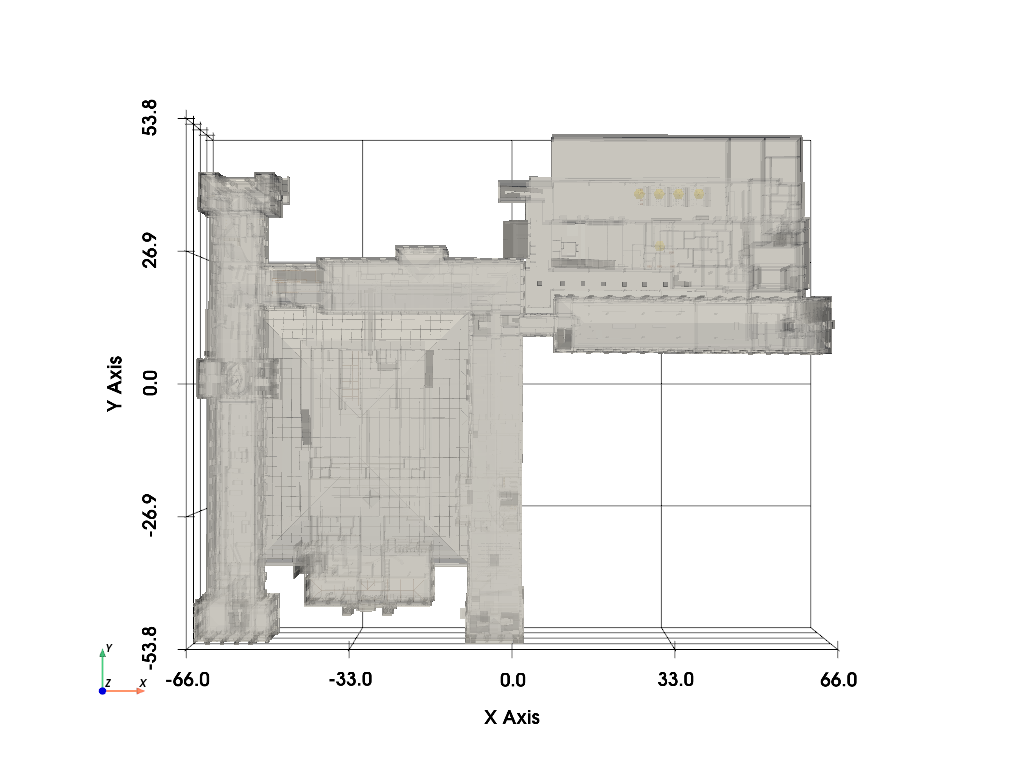

In [16]:
dh.plot_meshes()

In [17]:
analyser = MeshAnalyser(data_handler=dh)

In [18]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

02:18:18 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '13_OTHER'].
02:18:18 - INFO - Sampling with resolution 0.15.
02:18:19 - INFO - Number of points after initial sampling: 21334463
02:18:31 - INFO - Number of points after Poisson Disk Sampling: 2032474
02:18:31 - INFO - Number of points after initial sampling: 7294362
02:18:37 - INFO - Number of points after Poisson Disk Sampling: 1568594
02:18:37 - INFO - Number of points after initial sampling: 3816209
02:18:39 - INFO - Number of points after Poisson Disk Sampling: 308228
02:18:39 - INFO - Number of points after initial sampling: 8835339
02:18:43 - INFO - Number of points after Poisson Disk Sampling: 566297
02:18:43 - INFO - Number of points after initial sampling: 991451
02:18:43 - INFO - Number of points after Poisson Disk Sampling: 75436
02:18:44 - INFO - Number of points after initial sampling: 1507169
02:18:44 - INFO

In [19]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

02:18:47 - INFO - Binning is using 22 bins in X and 18 bins in Y based on cell widths of 6.0 and 6.0.


02:18:50 - INFO - New best equality score: 155340969.9675 at iteration 1
02:18:50 - INFO - New best equality score: 221775.9377 at iteration 3
02:18:50 - INFO - New best equality score: 206920.3923 at iteration 5
02:18:50 - INFO - New best equality score: 119277.1265 at iteration 8
02:18:50 - INFO - New best equality score: 81766.0102 at iteration 11
02:18:50 - INFO - New best equality score: 44688.6860 at iteration 18
02:18:51 - INFO - New best equality score: 44419.2661 at iteration 47
02:18:51 - INFO - New best equality score: 28827.7196 at iteration 53
02:18:52 - INFO - New best equality score: 27656.6140 at iteration 143
02:18:52 - INFO - New best equality score: 20215.9988 at iteration 158
02:18:59 - INFO - Number of unique seed cell configurations = 500


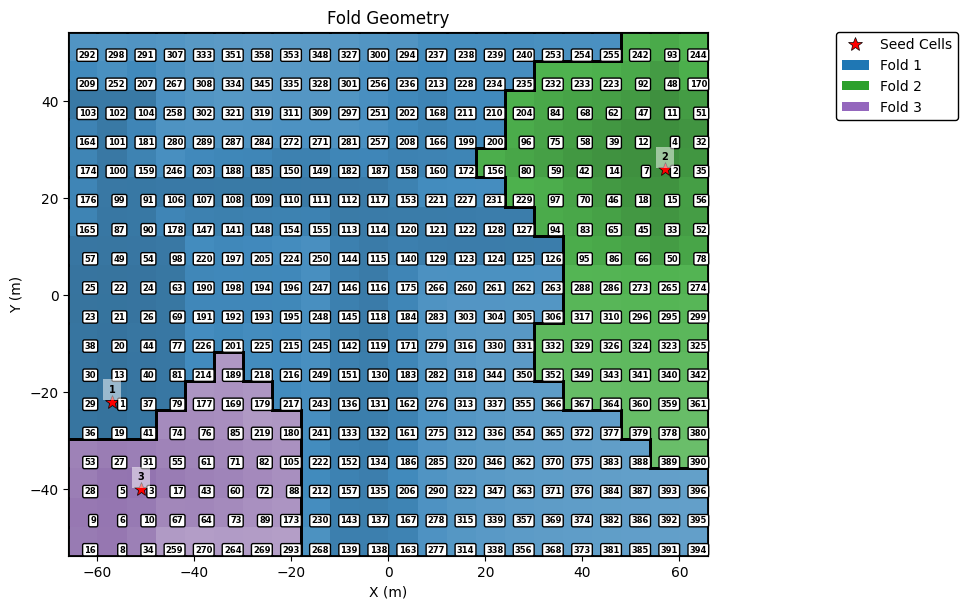

Iteration: 158

Fold Summaries:

Fold 1:
  Intended total counts: 3155948.25
  Actual total counts: 3110965.0
  Category Counts:
    1_WALL: 1255283.0 (61.76% of total 1_WALL)
    2_FLOOR: 999636.0 (63.73% of total 2_FLOOR)
    3_ROOF: 222503.0 (72.19% of total 3_ROOF)
    4_CEILING: 379418.0 (67.00% of total 4_CEILING)
    7_COLUMN: 43614.0 (57.82% of total 7_COLUMN)
    8_DOOR: 31696.0 (54.40% of total 8_DOOR)
    9_WINDOW: 41684.0 (72.23% of total 9_WINDOW)
    10_STAIR: 29589.0 (68.06% of total 10_STAIR)
    11_RAILING: 23332.0 (69.01% of total 11_RAILING)
    13_OTHER: 84210.0 (75.86% of total 13_OTHER)
  Aspect Ratio: 1.22

Fold 2:
  Intended total counts: 971061.00
  Actual total counts: 1017907.0
  Category Counts:
    1_WALL: 452969.0 (22.29% of total 1_WALL)
    2_FLOOR: 350122.0 (22.32% of total 2_FLOOR)
    3_ROOF: 35360.0 (11.47% of total 3_ROOF)
    4_CEILING: 113758.0 (20.09% of total 4_CEILING)
    7_COLUMN: 13727.0 (18.20% of total 7_COLUMN)
    8_DOOR: 14982.0 (25.71%

In [20]:
weights = {1: 0.65, 2: 0.2, 3: 0.15}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 1, 3: 1}
iterations = 500  # Number of iterations to run

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)
grid_splitter.min_percentage_threshold = 10.0

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

02:19:32 - INFO - Fold 1, Region 1: Found 17 rectangles with total perimeter 198


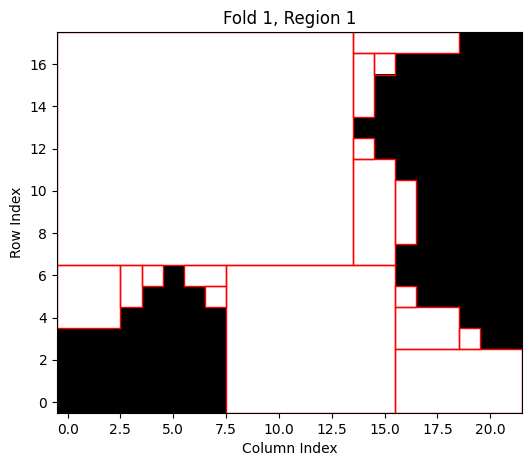

02:19:32 - INFO - Fold 2, Region 2: Found 9 rectangles with total perimeter 84


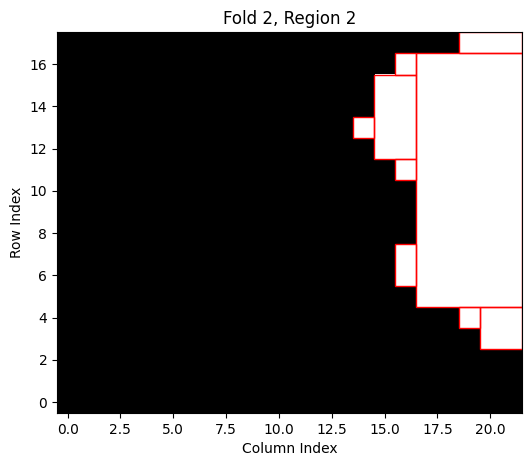

02:19:32 - INFO - Fold 3, Region 3: Found 5 rectangles with total perimeter 46


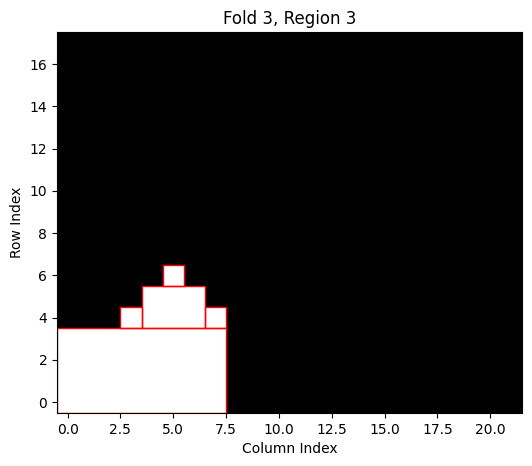

In [21]:
fold_rectangles = best_config.generate_fold_rectangles(combine_subregions=False)

In [22]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    fold_rectangles,
    best_config.x_edges,
    best_config.y_edges,
)

02:19:37 - INFO - Processing Region 1 in Fold 1
02:21:09 - INFO - Processing Region 2 in Fold 2
02:21:32 - INFO - Processing Region 3 in Fold 3


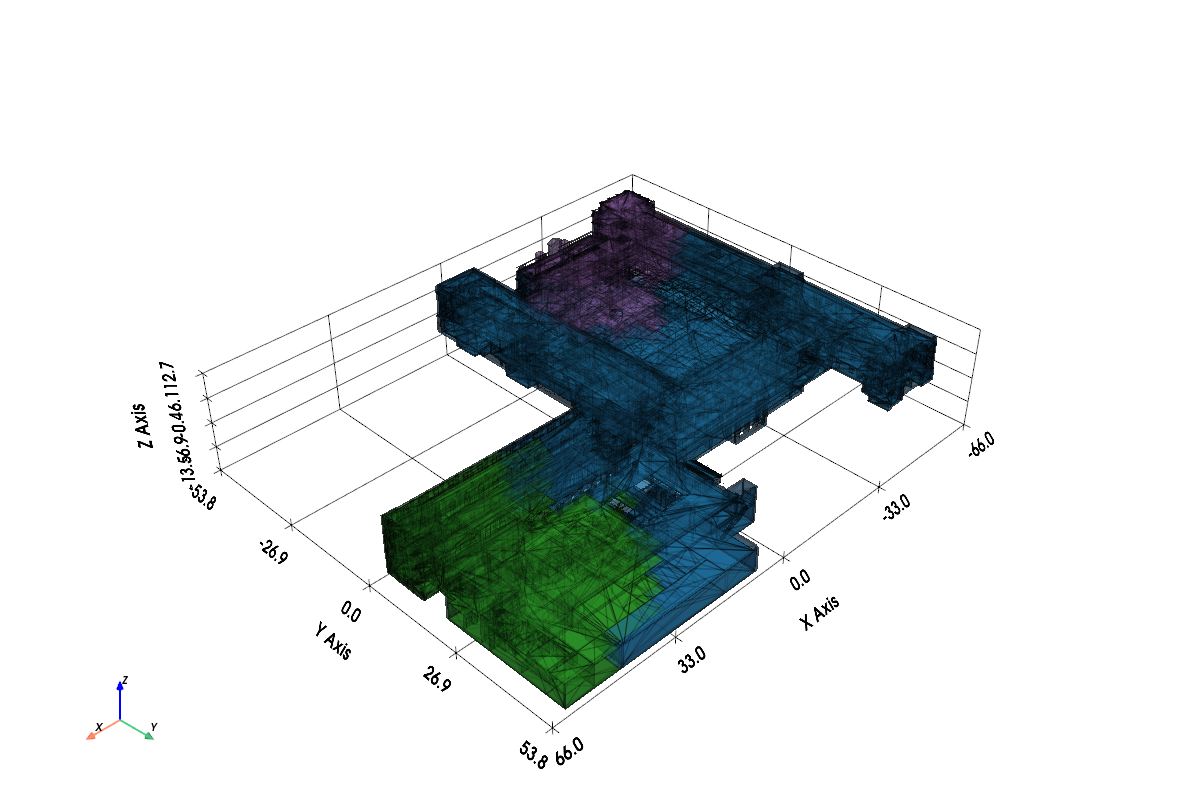

In [23]:
plot_mesh_folds(fold_meshes, backend='static', cmap='tab20')

In [24]:
best_config.save(f"../../fold_allocations/{label}_v1.pkl")

In [25]:
save_fold_meshes(dh, fold_meshes)

02:23:06 - INFO - Saved Fold 1, Region 1, Category '1_WALL' to ../../data/meshes/extracted/maritime_museum/train/1_wall_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Category '2_FLOOR' to ../../data/meshes/extracted/maritime_museum/train/2_floor_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Category '3_ROOF' to ../../data/meshes/extracted/maritime_museum/train/3_roof_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Category '4_CEILING' to ../../data/meshes/extracted/maritime_museum/train/4_ceiling_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Category '7_COLUMN' to ../../data/meshes/extracted/maritime_museum/train/7_column_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Category '8_DOOR' to ../../data/meshes/extracted/maritime_museum/train/8_door_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Category '9_WINDOW' to ../../data/meshes/extracted/maritime_museum/train/9_window_sceneid1.ply.
02:23:06 - INFO - Saved Fold 1, Region 1, Cate